In [23]:
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

font = {'family' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)


In [24]:
with open("data/config.json") as f:
    config = json.load(f)
candidates = {}
name_to_district = {}
for district in config["ballots_config"]:
    for id_, name in district["options"].items():
        candidates[int(id_)] = name
        name_to_district[name] = district["district_id"]

FORMAT = "%Y-%m-%dT%H:%M:%S"
LEN = len("2021-09-17T08:18:18")

def read(fname):
    times = {
        name: [] for name in candidates.values()
    }
    with open(fname) as f:
        for l in f:
            d = json.loads(l)
            if d["vote"] in candidates:
                date = datetime.strptime(d["datetime"][:LEN], FORMAT)
                times[candidates[d["vote"]]].append(date.timestamp() - 3 * 60 * 60)
                
    votes_by_district = {
        id_: {} for id_ in name_to_district.values()
    }
    for name, votes in times.items():
        votes_by_district[name_to_district[name]][name] = len(votes)
    return times, votes_by_district

times_all, votes_all = read("data/vote_times.jsonl")
# times_decrypted = read("vote_times_decrypted.jsonl")

In [25]:
def make_ticks():
    ticks = []
    labels = []
    for hours in range(8, 24 * 2 + 22, 2):
        d = datetime(2021, 9, 17) + timedelta(hours=hours)
        ticks.append((d - timedelta(hours=3)).timestamp())
        if d.hour == 0:
            labels.append("{} сен".format(d.day))
        else:
            labels.append("{:02}".format(d.hour))
    return ticks, labels

def draw_comparison(times, name1, name2, district, colors=None):
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20,15))
    
    ns, bins, patches = ax1.hist(
        [times[name1], times[name2]],
        bins=70,
        stacked=False,
        color=colors,
        label=[name1, name2],
    )
    ax1.legend()
    ticks, labels = make_ticks()
    ax1.set_xticks(ticks)
    ax1.set_xticklabels(labels)
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_ylabel('Количество голосов в интервале')
    
    ax2.bar(bins[:-1], ns[1] / ns[0], width=2*patches[0].get_children()[0].get_width())
    ax2.set_ylabel('Отношение {} / {}'.format(name2.split()[0], name1.split()[0]))
    
    ax2.set_xticks(ticks)
    ax2.set_xticklabels(labels)
    ax2.tick_params(axis='x', rotation=45)
    
    plt.savefig("images/Comparison_{}_{}_{}.png".format(district, name1.split()[0], name2.split()[0]))

In [26]:
def find(substr):
    matching = [name for name in candidates.values() if substr.upper() == name.split()[0].upper()]
    assert len(matching) == 1, matching
    return matching[0]

In [27]:
def analyze_top_3_in_district(district, votes, times):
    print("Processing", district)
    s = sorted(votes.items(), key=lambda t: -t[1])
    draw_comparison(times, s[1][0], s[0][0], district, colors=["red", "blue"])
    draw_comparison(times, s[2][0], s[1][0], district, colors=["green", "red"])

Processing 197


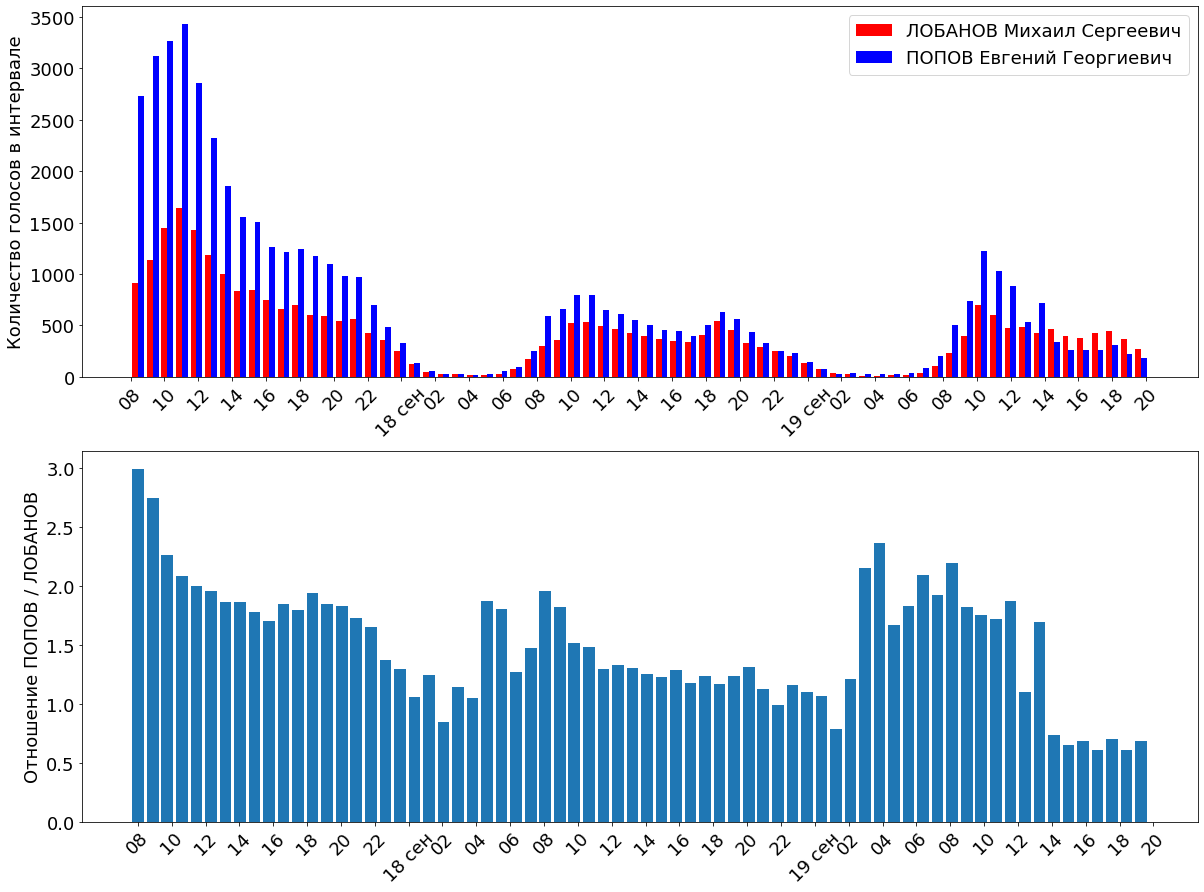

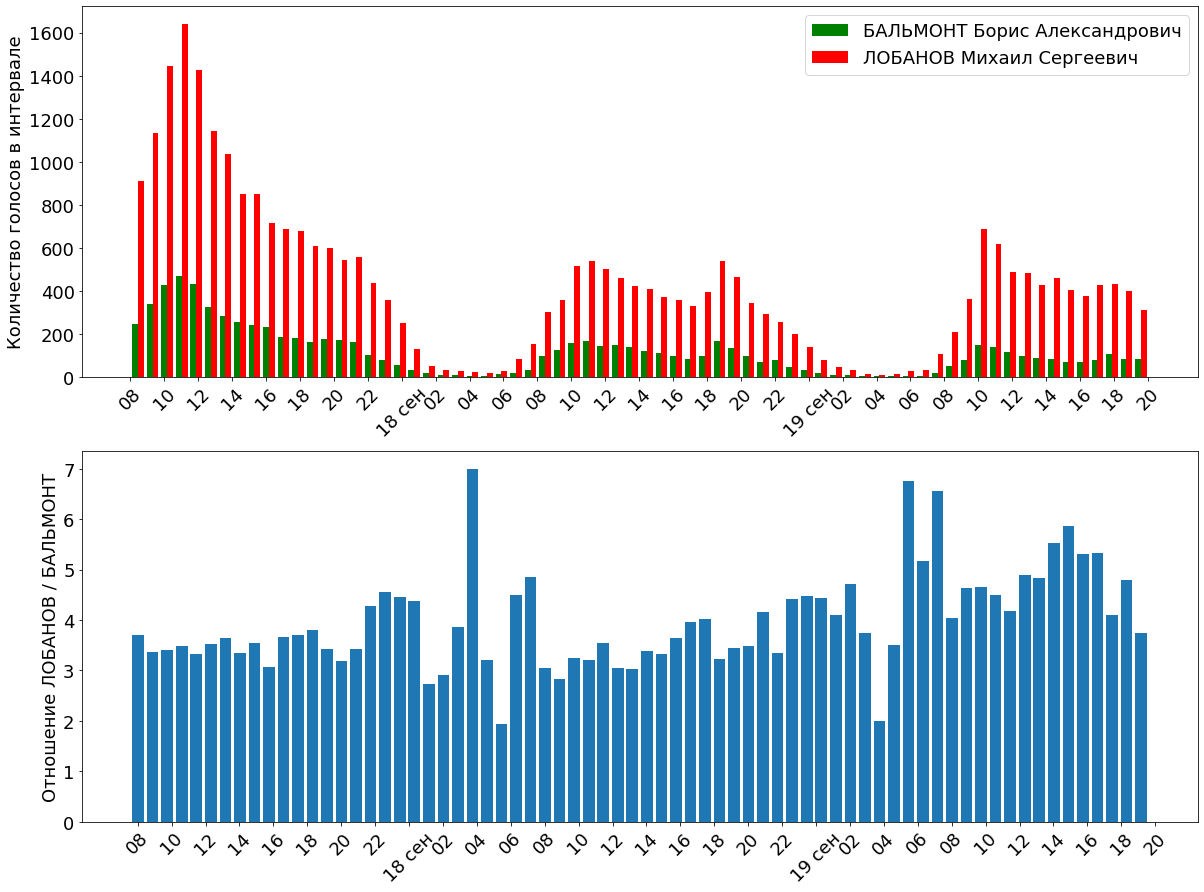

In [28]:
analyze_top_3_in_district(197, votes_all[197], times_all)

In [ ]:
for district, votes in votes_all.items():
    analyze_top_3_in_district(district, votes, times_all)